<a href="https://colab.research.google.com/github/bongkyunSON/Fastcampus-ML/blob/main/ML_project_221121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Load

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.8 MB/s 
     |████████████████████████████████| 209 kB 34.6 MB/s 
     |████████████████████████████████| 81 kB 9.2 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 112 kB 53.1 MB/s 
     |████████████████████████████████| 50 kB 4.8 MB/s 
     |████████████████████████████████| 147 kB 53.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=9517f596b00e41db8213cd6fc0341ab853d462fb432934c8e185647276d99df0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import warnings
warnings.filterwarnings(action='ignore')

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, Binarizer
from sklearn.model_selection import train_test_split, GridSearchCV

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# classification metrics
from sklearn.metrics import confusion_matrix, plot_roc_curve, f1_score

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor

# regression metrics
from sklearn.metrics import mean_absolute_error, r2_score

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold, StratifiedKFold
from functools import partial

# optimize : hyper-parameter tuning
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler


In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/MachineLearning/data/Construction_machinery/'


train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')
submission = pd.read_csv(base_path + 'sample_submission.csv')

In [ ]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,NaN,NaN,NaN,NaN,NaN,0,14.5,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.0,8.0,100.0,1625.0,18890.0,0,NaN,44.3,652,0


In [ ]:
test

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,TEST_0001,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,TEST_0002,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,TEST_0003,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,TEST_0004,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,TEST_6036,COMPONENT3,1714,2014,200,0,0,3,130,1047,0.0,65,5,2,1999,0,0,71.2,1163
6037,TEST_6037,COMPONENT3,4131,2016,200,0,0,5,2,736,0.0,5,0,0,693,0,0,137.8,13
6038,TEST_6038,COMPONENT3,4325,2014,200,0,0,0,0,53,0.0,0,0,0,69,0,0,302.2,13
6039,TEST_6039,COMPONENT2,1364,2013,200,0,0,0,62,2,0.0,0,0,0,5,0,0,51.1,478


In [ ]:
submission

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
6036,TEST_6036,0
6037,TEST_6037,0
6038,TEST_6038,0
6039,TEST_6039,0


# EDA

정상 개수 in train data set : 12892개
불량 개수 in train data set : 1203개
불량 비율 : 8.534941468605888%


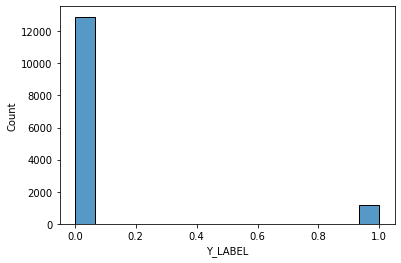

In [ ]:
sns.histplot(data=train, x='Y_LABEL')
print(f"정상 개수 in train data set : {len(train[train.Y_LABEL == 0])}개")
print(f"불량 개수 in train data set : {len(train[train.Y_LABEL == 1])}개")
print(f"불량 비율 : {100 * len(train[train.Y_LABEL == 1]) / len(train)}%")

In [ ]:
print(train['COMPONENT_ARBITRARY'].unique())
component_dict = {'COMPONENT3': 3, 'COMPONENT2': 2, 'COMPONENT1': 1, 'COMPONENT4': 4}

['COMPONENT3' 'COMPONENT2' 'COMPONENT1' 'COMPONENT4']


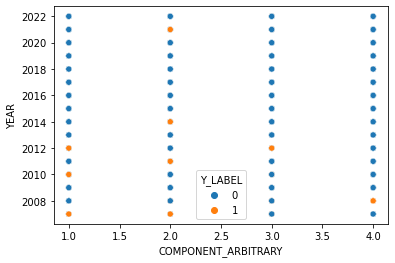

In [ ]:
train.COMPONENT_ARBITRARY = train.COMPONENT_ARBITRARY.map(component_dict)
sns.scatterplot(data=train, x='COMPONENT_ARBITRARY', y='YEAR', hue='Y_LABEL')

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


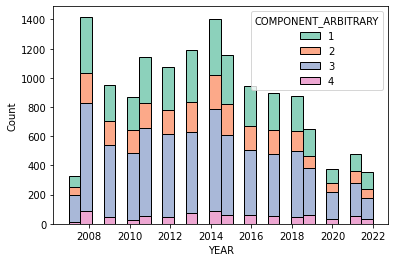

In [ ]:
print(sorted(train.YEAR.unique().tolist()))
sns.histplot(data=train, x='YEAR', hue='COMPONENT_ARBITRARY', multiple="stack", palette='Set2')

Component1의 전체 개수 in train data set : 3890개
Component1의 정상 개수 in train data set : 3578개
Component1의 불량 개수 in train data set : 312개
Component1의 불량 비율 : 8.020565552699228%
Component2의 전체 개수 in train data set : 2316개
Component2의 정상 개수 in train data set : 2110개
Component2의 불량 개수 in train data set : 206개
Component2의 불량 비율 : 8.894645941278066%
Component3의 전체 개수 in train data set : 7050개
Component3의 정상 개수 in train data set : 6415개
Component3의 불량 개수 in train data set : 635개
Component3의 불량 비율 : 9.00709219858156%
Component4의 전체 개수 in train data set : 839개
Component4의 정상 개수 in train data set : 789개
Component4의 불량 개수 in train data set : 50개
Component4의 불량 비율 : 5.959475566150179%


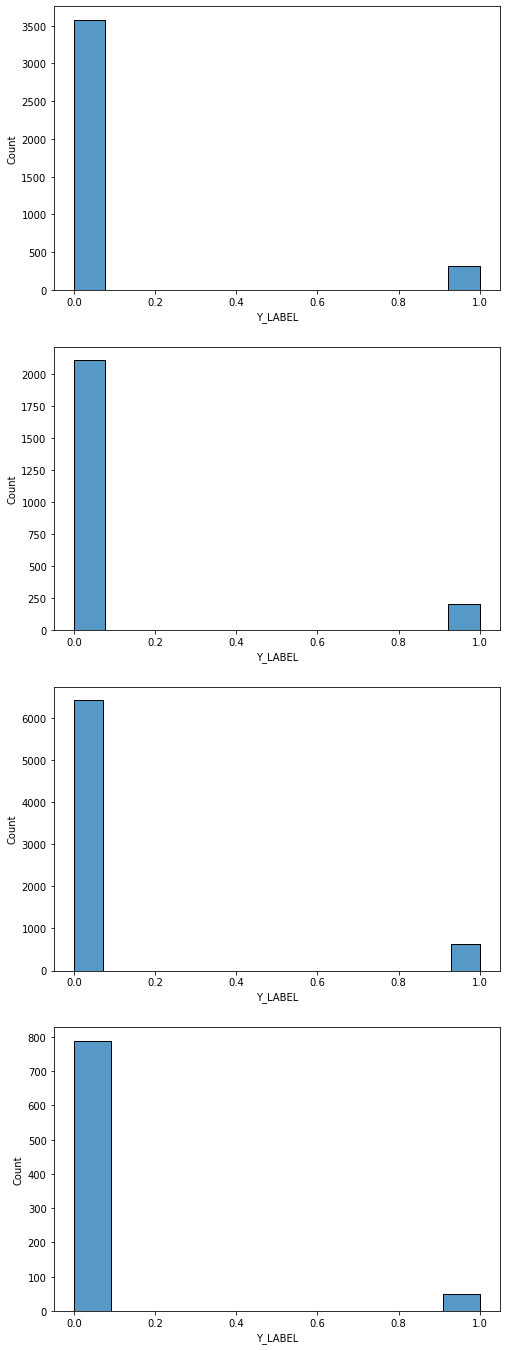

In [ ]:
_,ax = plt.subplots(4, 1, figsize=(8, 24))

for component in range(1, 5):
    temp = train[train.COMPONENT_ARBITRARY == component]
    sns.histplot(data=temp, x='Y_LABEL', ax=ax[component-1])
    print(f"Component{component}의 전체 개수 in train data set : {len(temp)}개")
    print(f"Component{component}의 정상 개수 in train data set : {len(temp[temp.Y_LABEL == 0])}개")
    print(f"Component{component}의 불량 개수 in train data set : {len(temp[temp.Y_LABEL == 1])}개")
    print(f"Component{component}의 불량 비율 : {100 * len(temp[temp.Y_LABEL == 1]) / len(temp)}%")

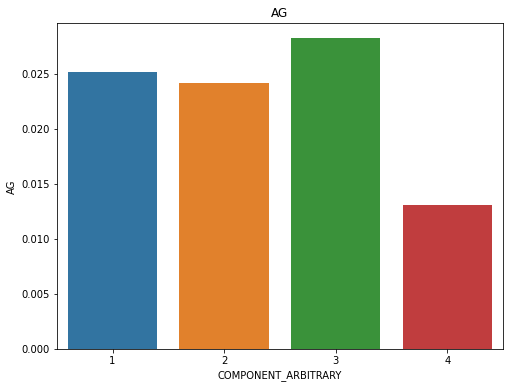

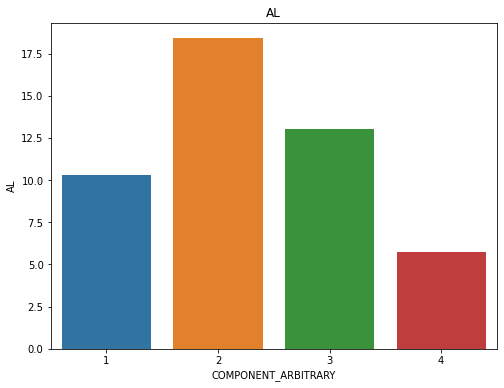

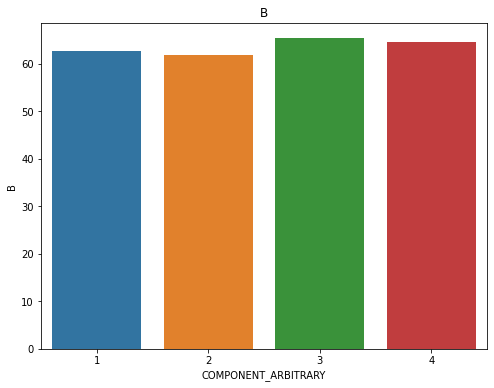

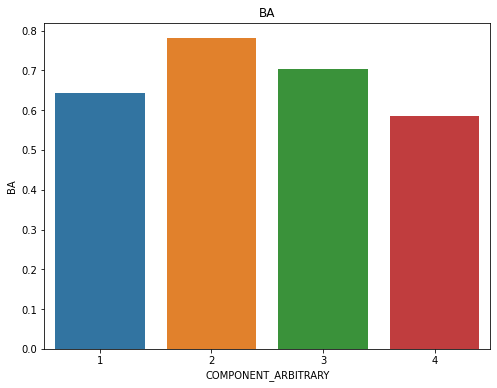

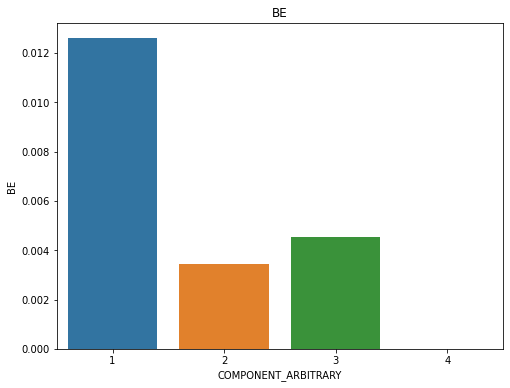

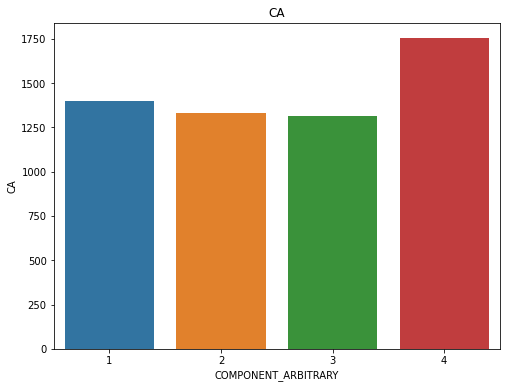

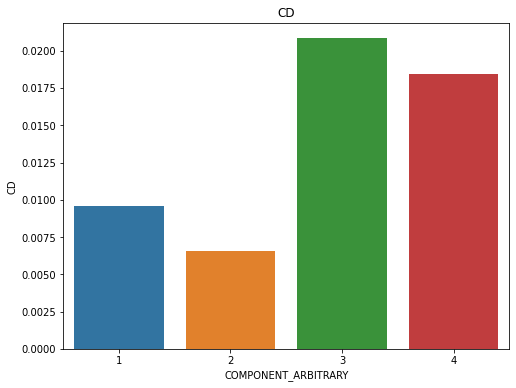

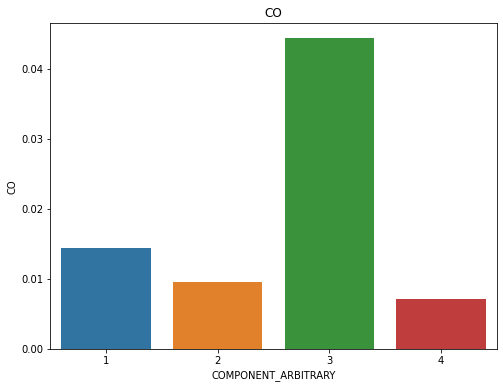

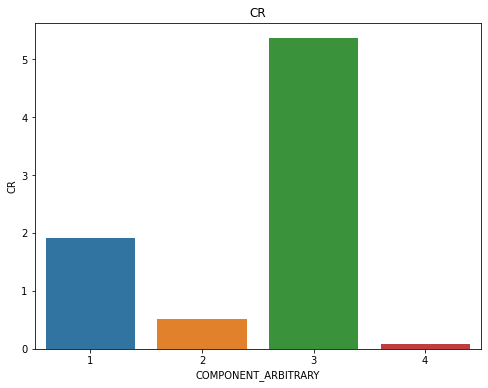

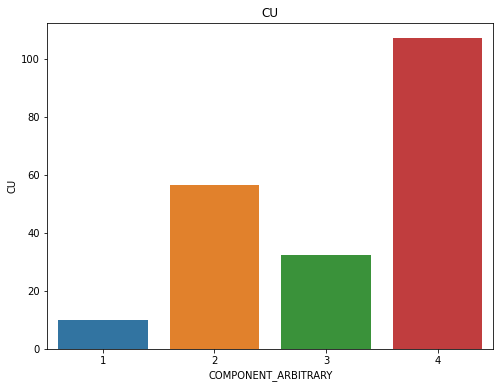

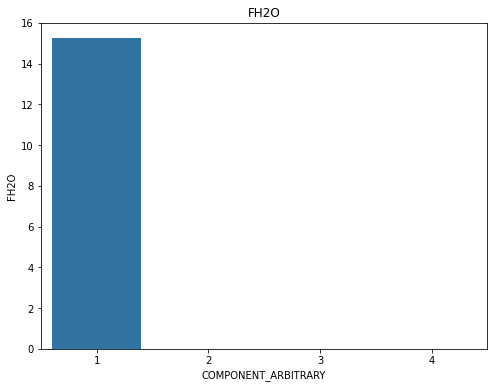

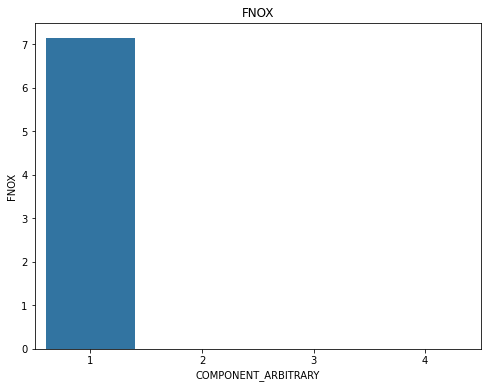

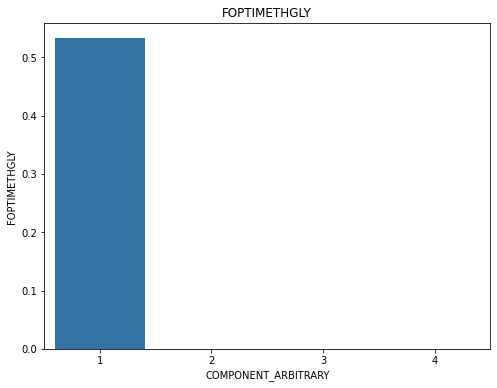

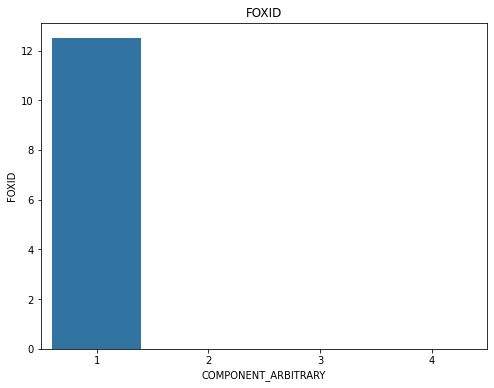

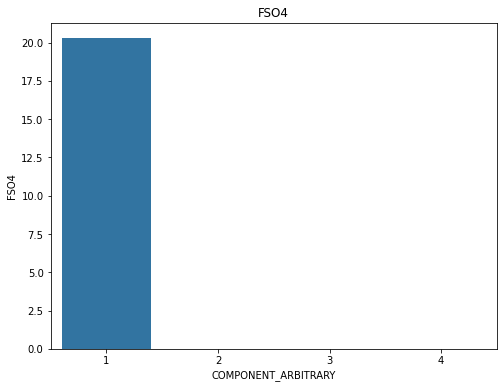

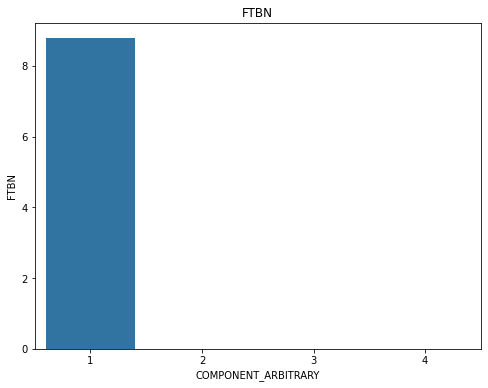

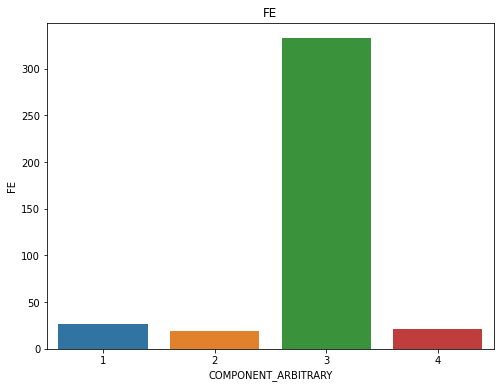

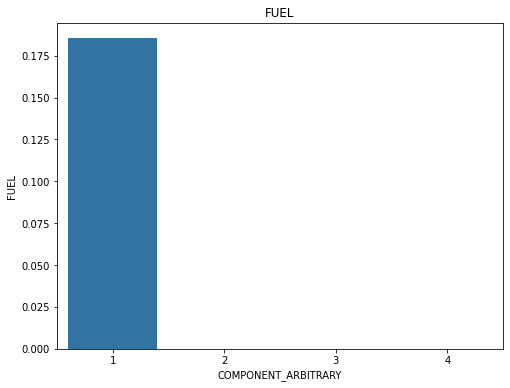

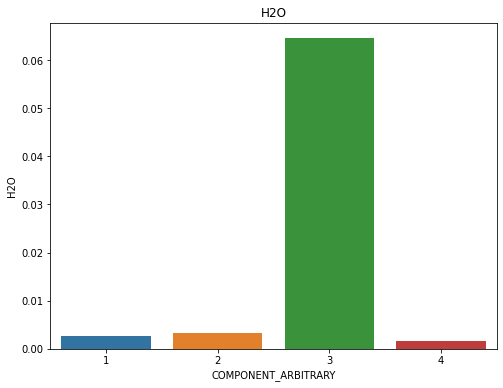

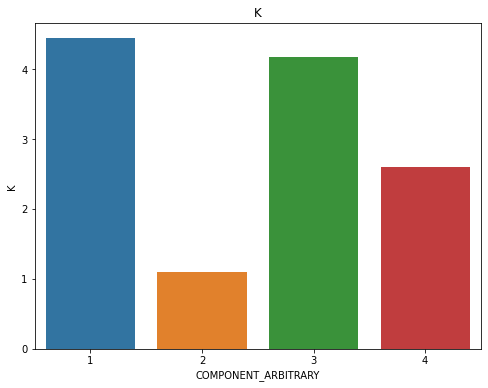

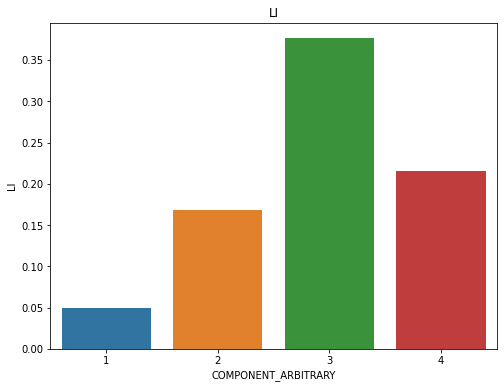

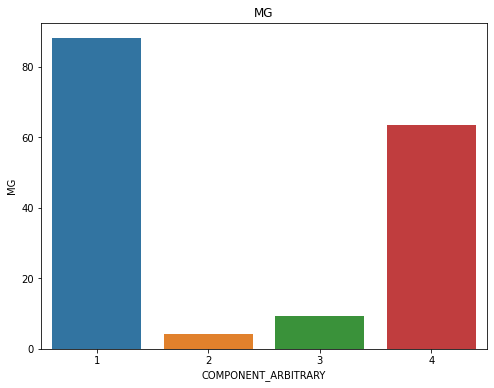

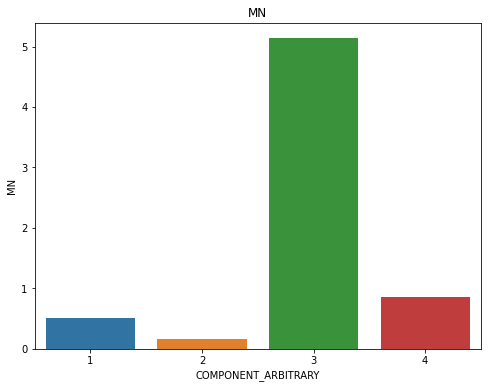

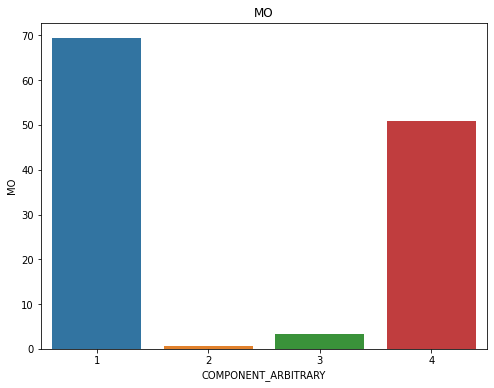

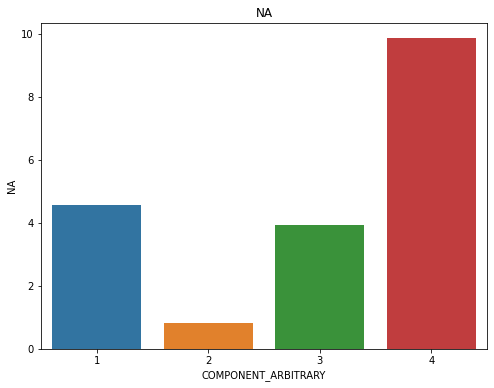

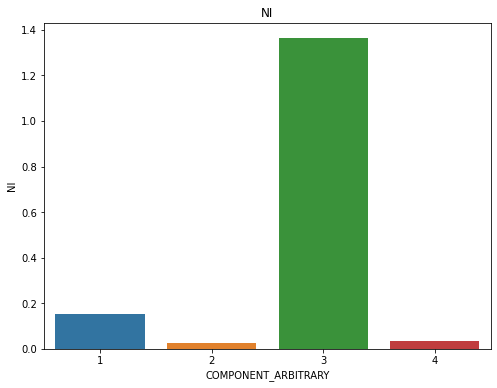

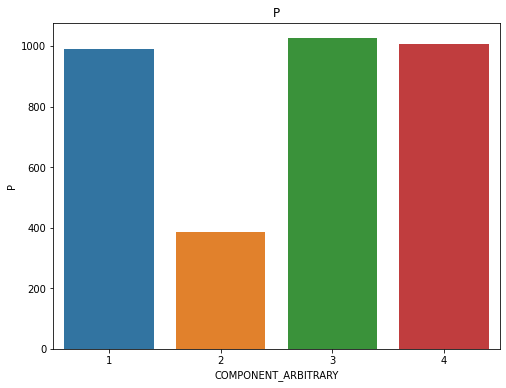

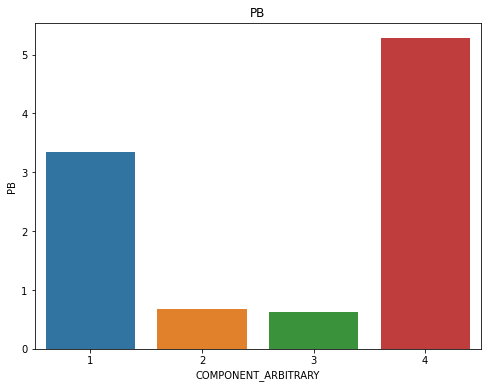

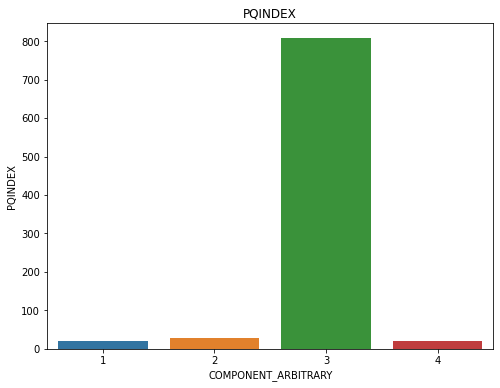

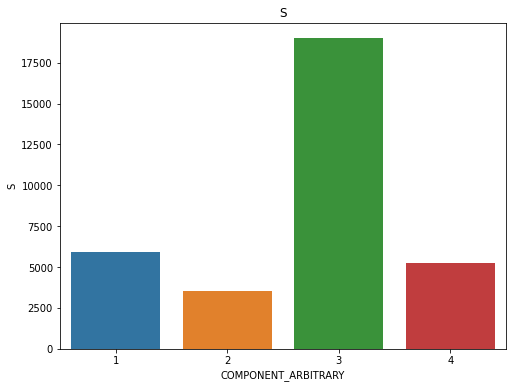

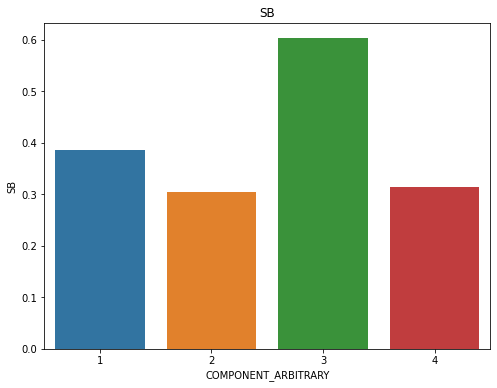

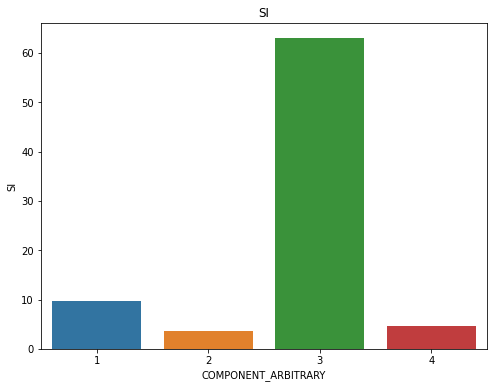

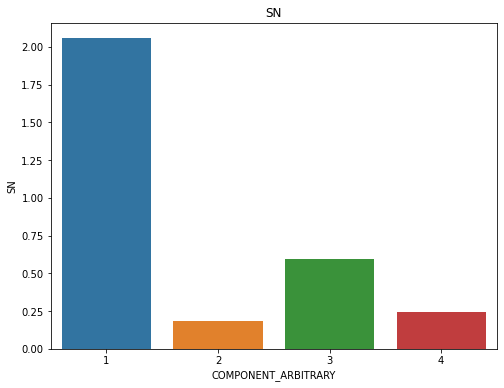

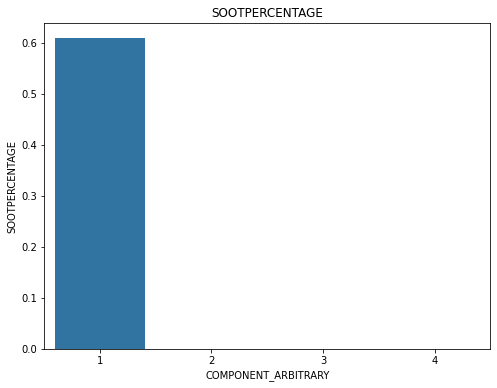

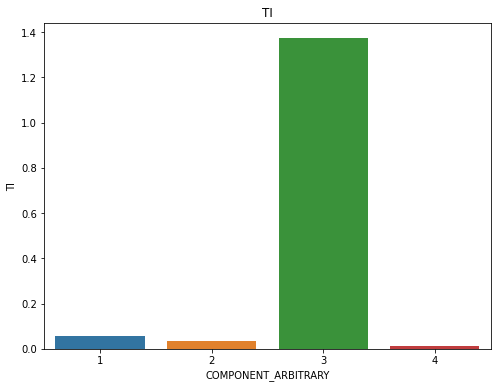

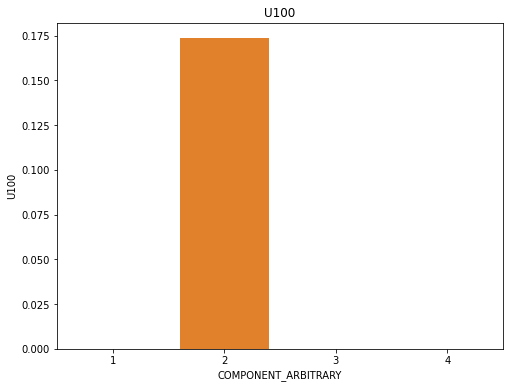

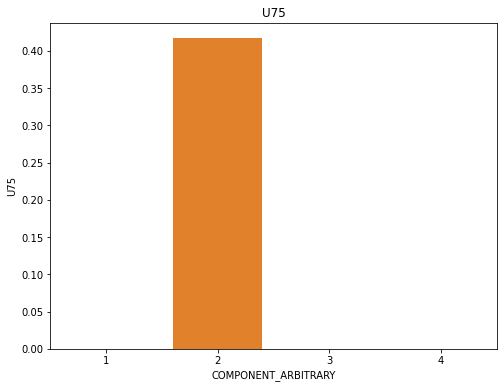

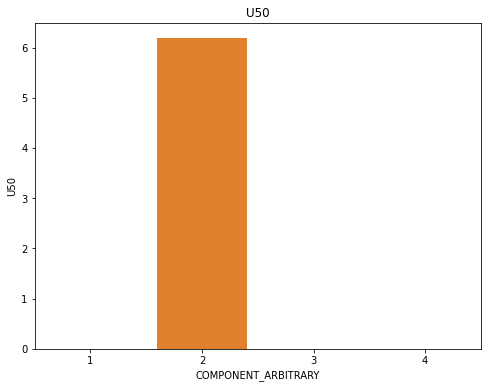

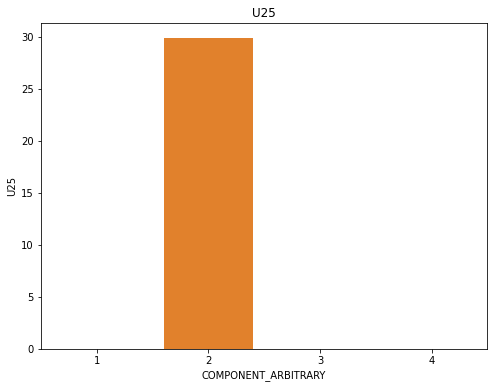

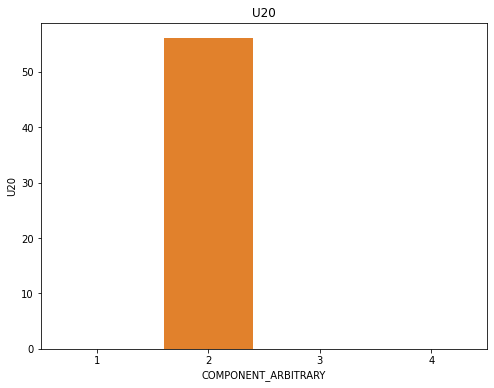

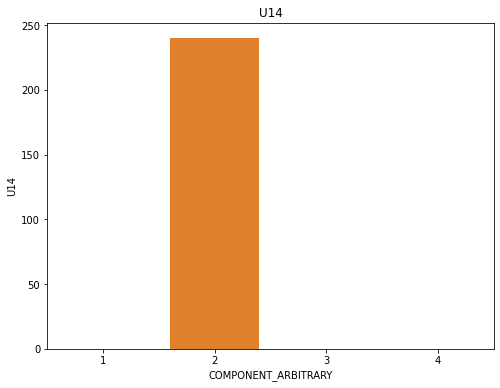

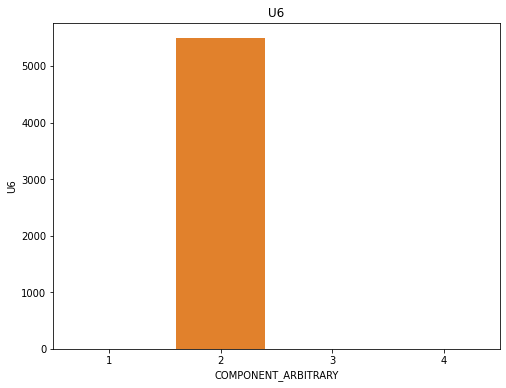

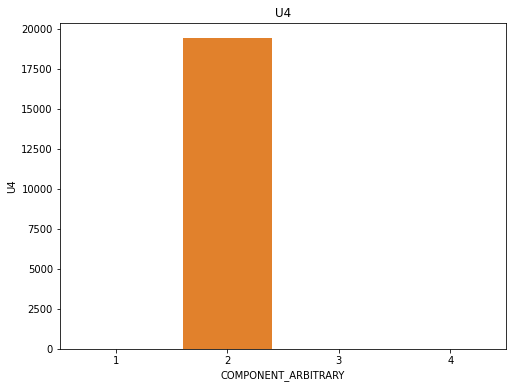

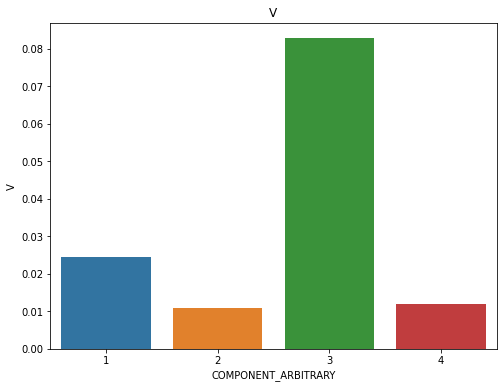

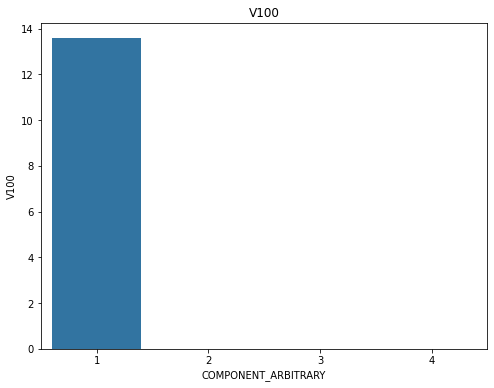

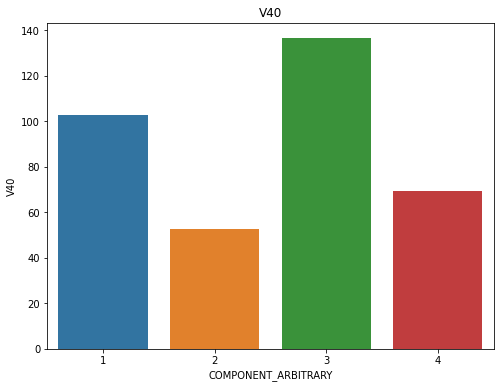

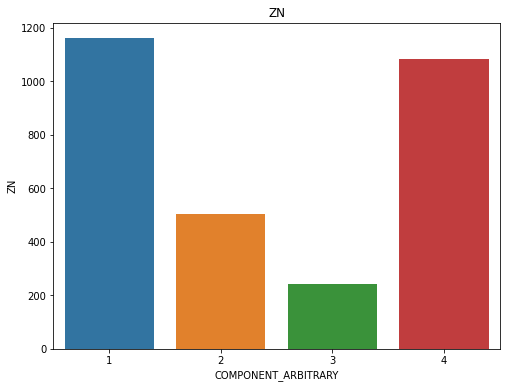

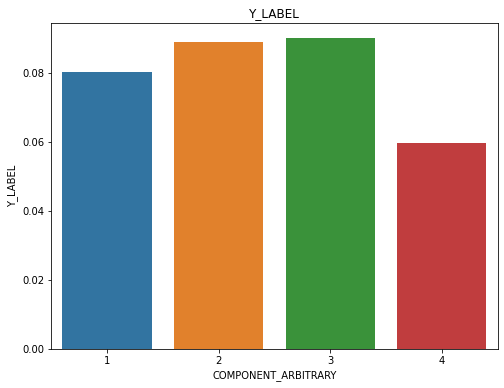

In [ ]:
train_list = ['AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL']



for n in range(len(train_list)):
    plt.figure(figsize=(8, 6))
    plt.title(train_list[n])
    sns.barplot(data=train, x="COMPONENT_ARBITRARY", y=train_list[n], ci=None)
    plt.show()

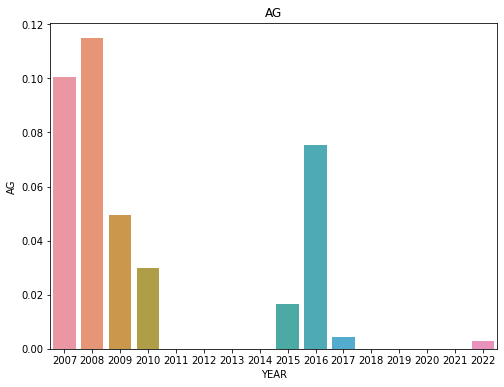

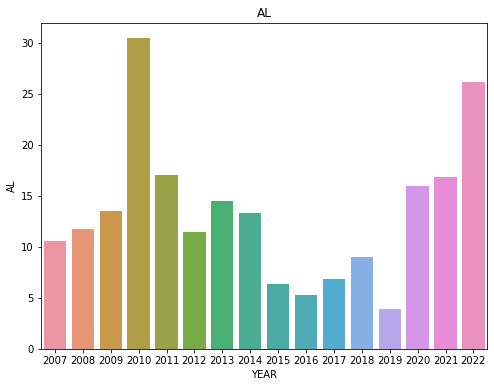

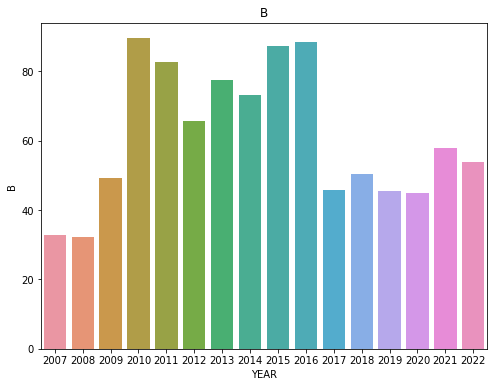

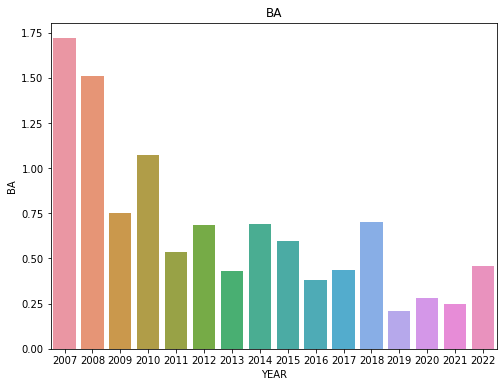

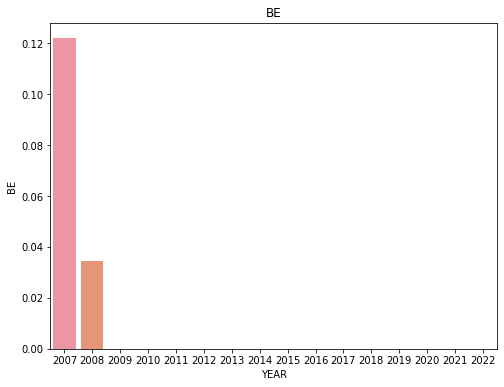

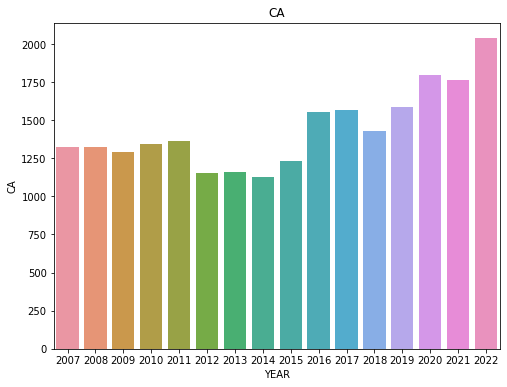

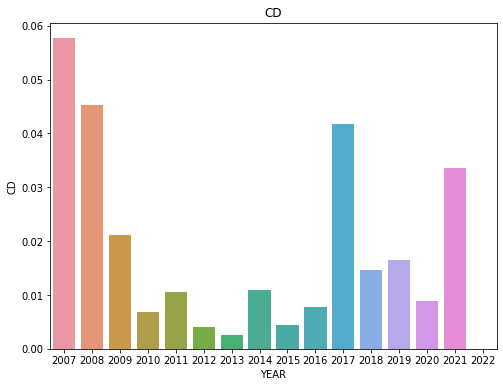

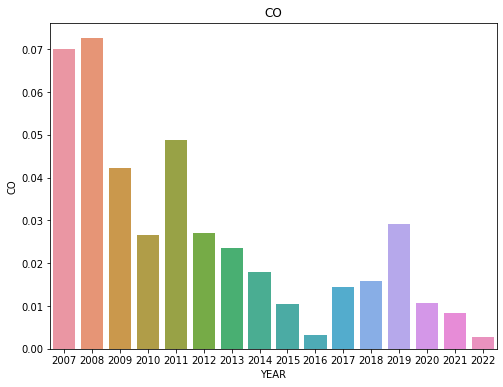

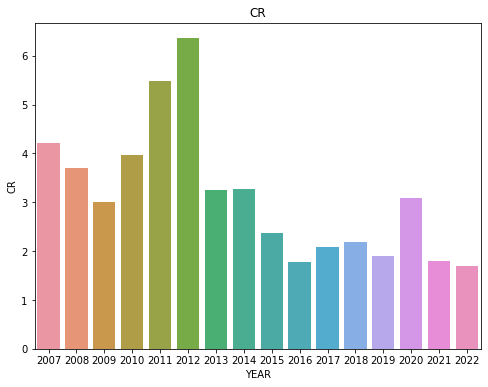

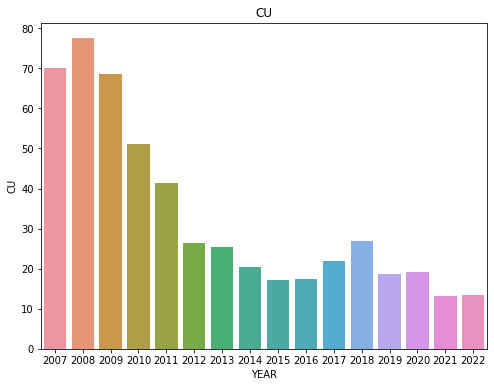

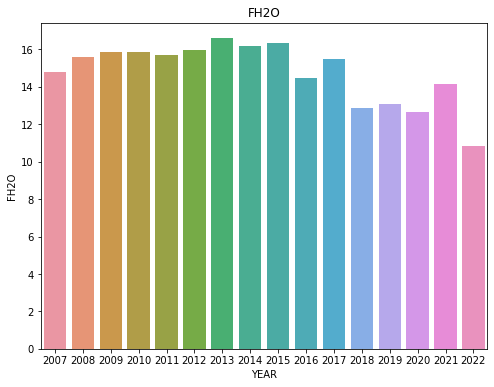

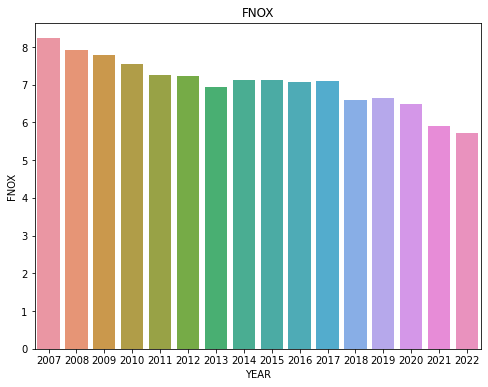

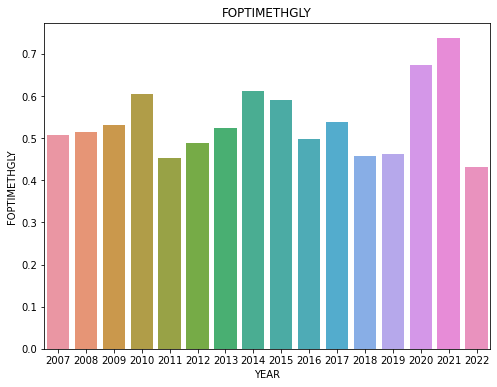

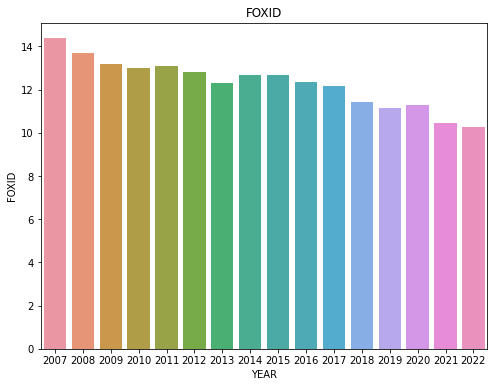

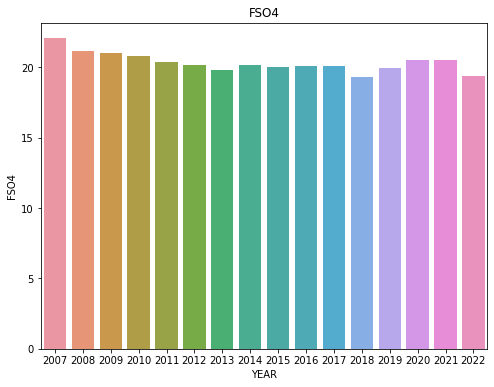

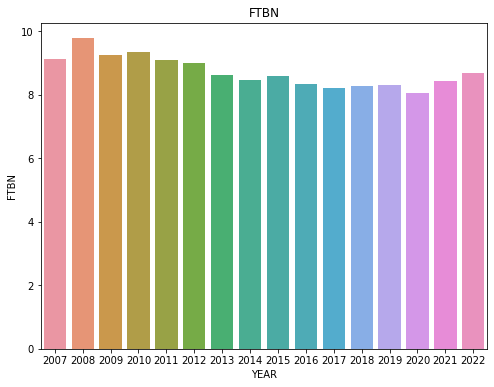

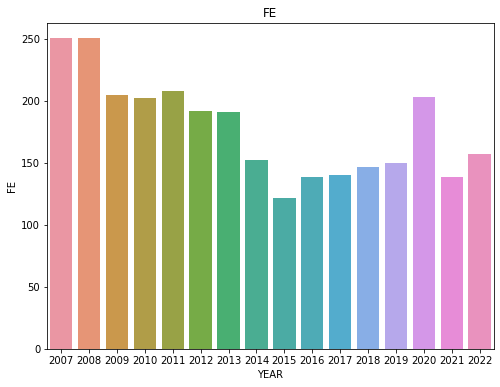

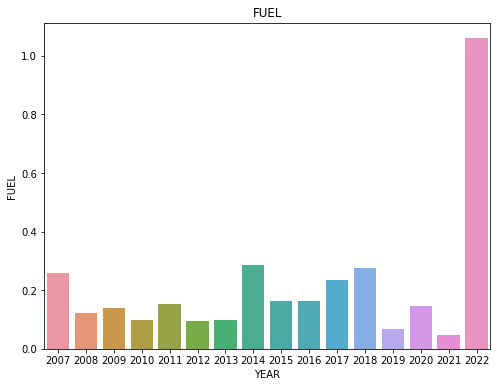

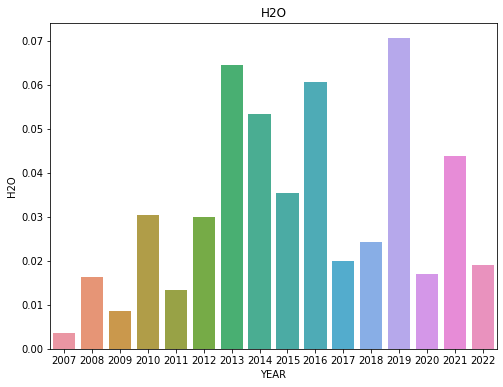

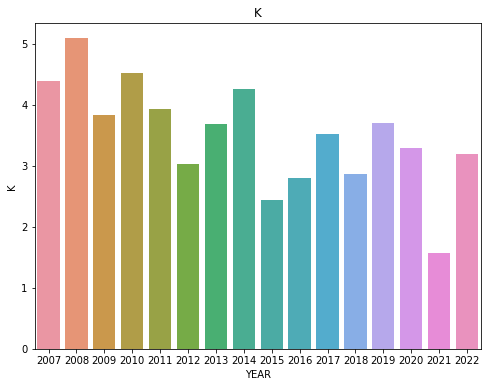

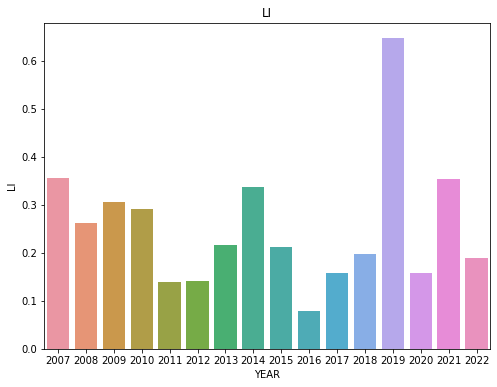

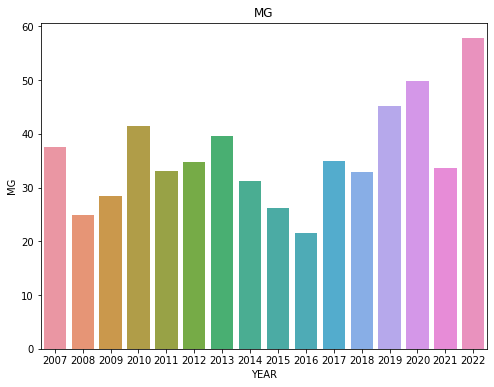

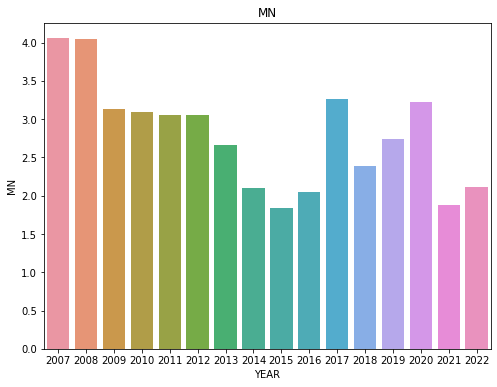

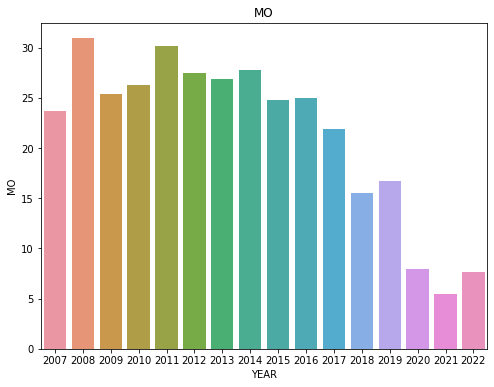

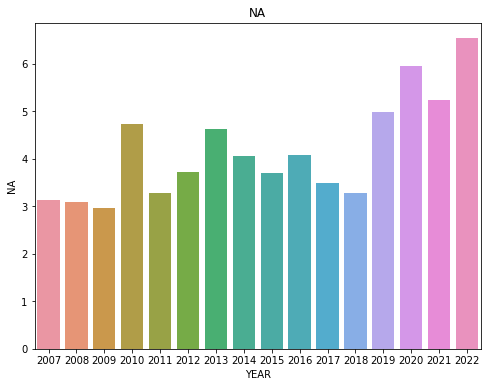

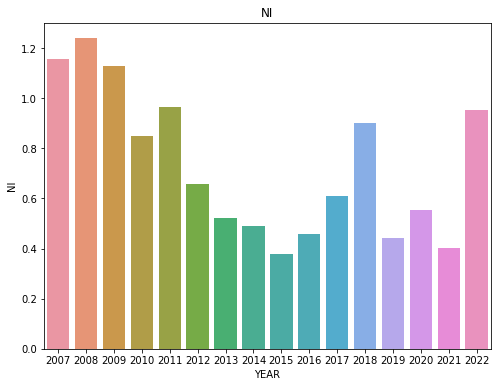

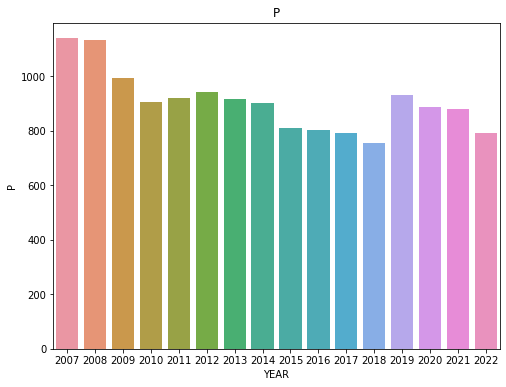

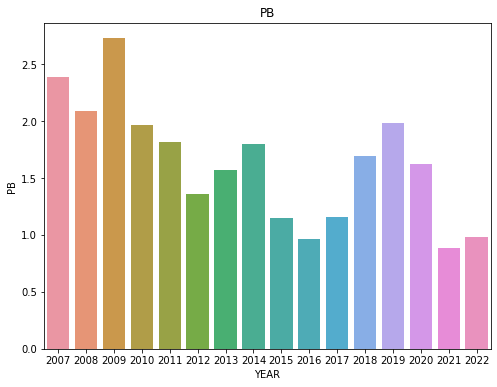

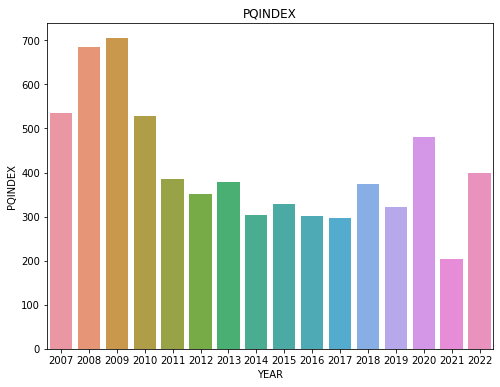

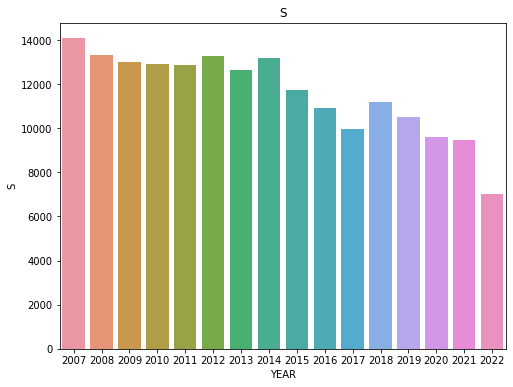

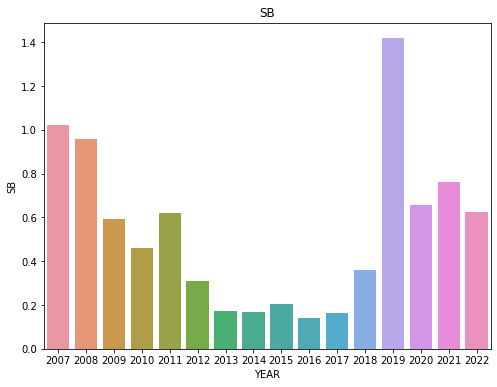

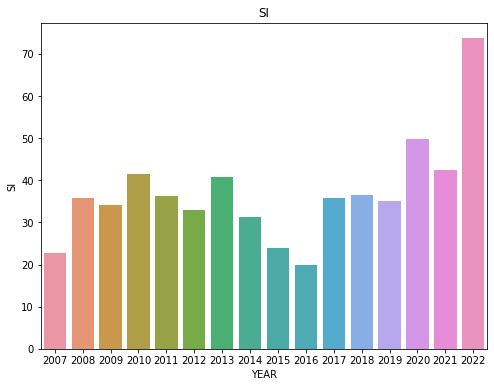

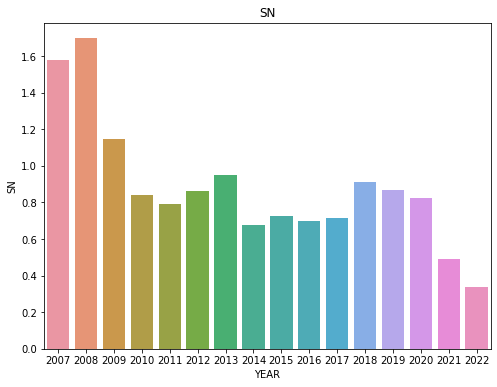

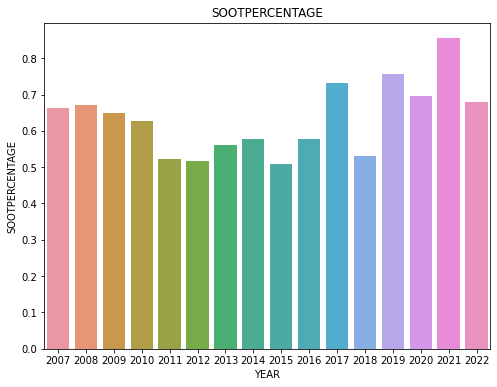

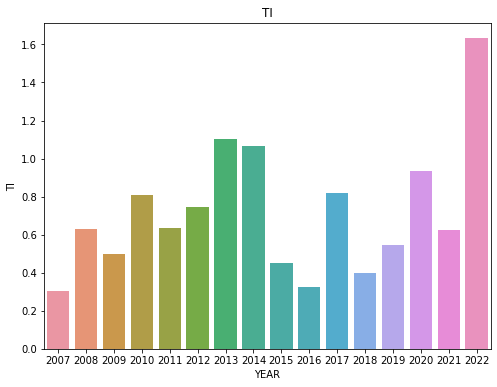

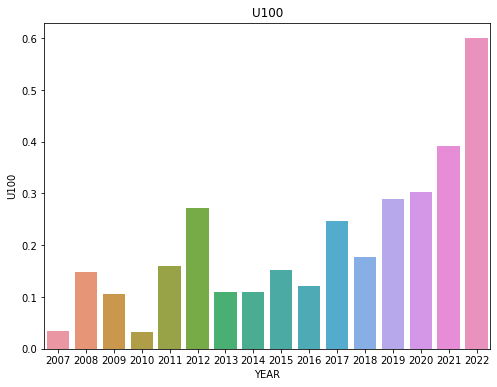

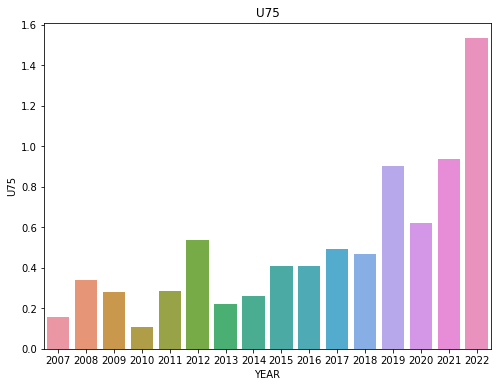

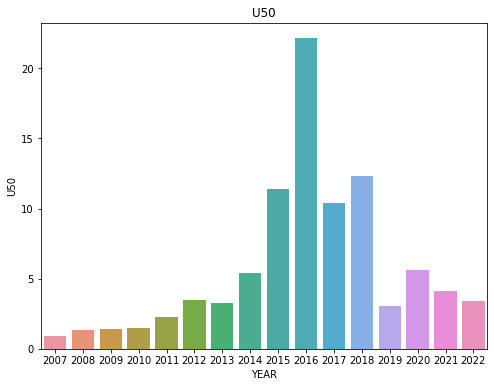

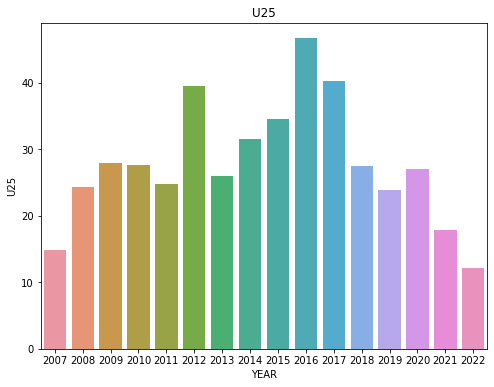

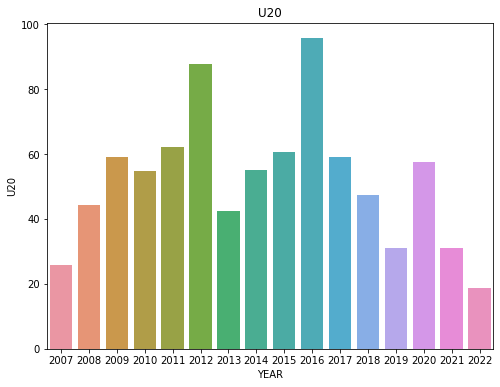

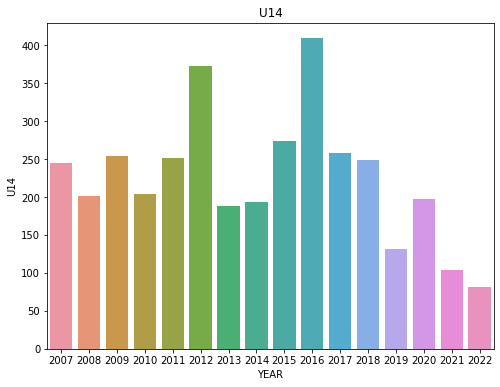

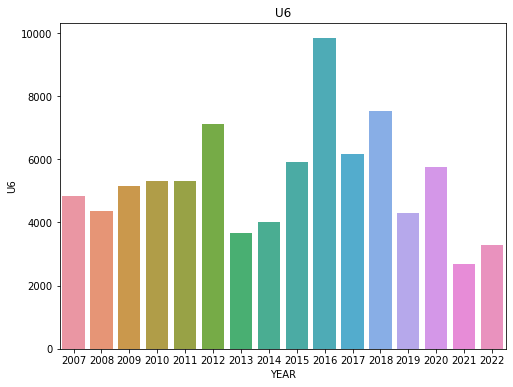

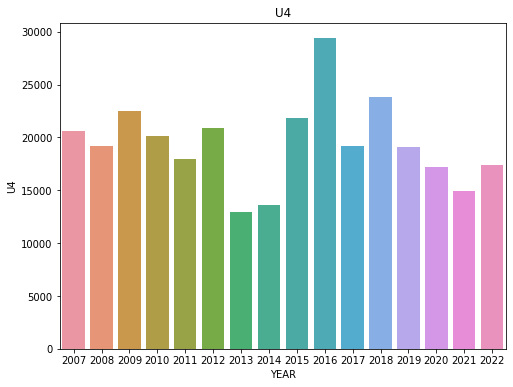

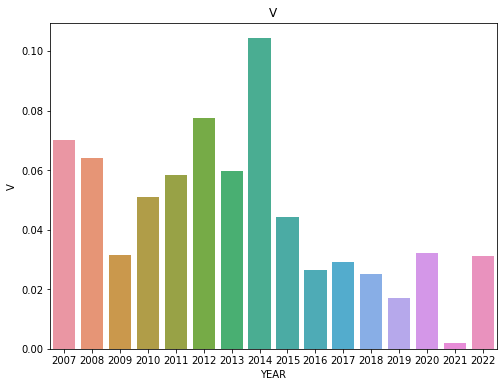

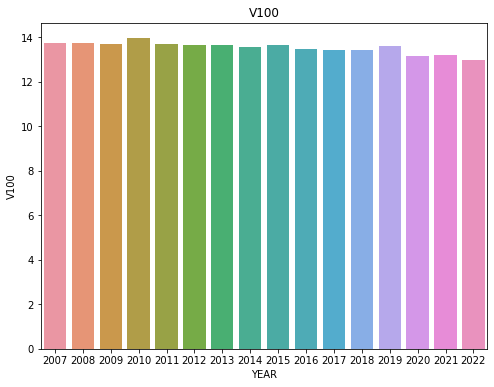

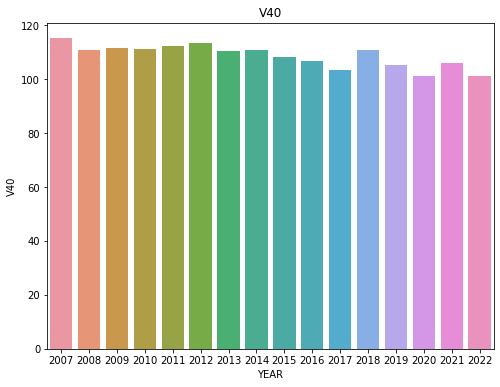

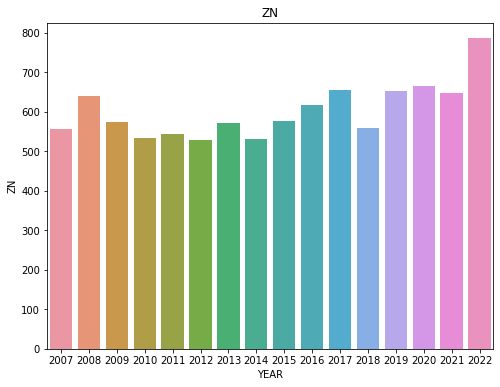

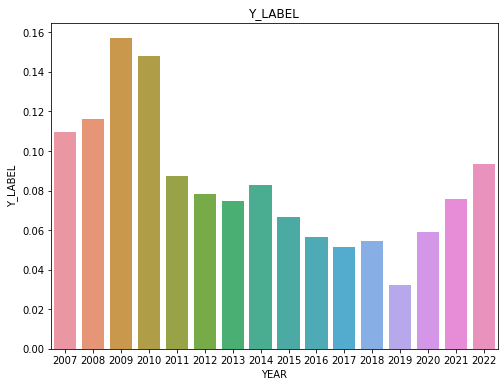

In [ ]:
train_list = ['AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL']



for n in range(len(train_list)):
    plt.figure(figsize=(8, 6))
    plt.title(train_list[n])
    sns.barplot(data=train, x="YEAR", y=train_list[n], ci=None)
    plt.show()

In [ ]:
#위에서 COMPONENT_ARBITRARY component_dict를 했기 떄문에 주석처리 해야한다
drop_col = ['ID', 'YEAR'] # B, CA
# preprocessing
# def preprocessing(train, test, drop_col, component_dict):

train = train.drop(columns=drop_col)
test = test.drop(columns=['ID', 'YEAR'])

# train.COMPONENT_ARBITRARY = train.COMPONENT_ARBITRARY.map(component_dict)
# test.COMPONENT_ARBITRARY = test.COMPONENT_ARBITRARY.map(component_dict)
train

,COMPONENT_ARBITRARY,ANONYMOUS_1,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,3,1486,7,200,0,3,93,0,0,3059,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,2,1350,51,375,0,2,19,0,0,2978,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,2,2415,2,200,0,110,1,1,0,17,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,3,7389,2,200,0,8,3,0,0,1960,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,3,3954,4,200,0,1,157,0,0,71,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,3,1616,8,200,0,2,201,1,0,6,...,NaN,NaN,NaN,NaN,NaN,0,NaN,135.4,16,0
14091,1,2784,2,200,0,3,85,0,0,2945,...,NaN,NaN,NaN,NaN,NaN,0,14.5,117.5,1408,0
14092,3,1788,9,550,0,6,0,1,0,13,...,NaN,NaN,NaN,NaN,NaN,0,NaN,54.0,1301,0
14093,2,2498,19,550,0,2,4,0,0,2244,...,7.0,8.0,100.0,1625.0,18890.0,0,NaN,44.3,652,0


In [ ]:
train_cols = train.drop(columns='Y_LABEL').columns
test_cols = test.columns
resid_cols = list(set(train_cols) - set(test_cols))
print(len(train_cols))
print(len(test_cols))
print(resid_cols)

51
17
['SN', 'U50', 'PB', 'AL', 'U4', 'MG', 'SI', 'SB', 'U20', 'P', 'CA', 'FNOX', 'B', 'SOOTPERCENTAGE', 'U14', 'SAMPLE_TRANSFER_DAY', 'K', 'U100', 'S', 'U25', 'FOXID', 'U75', 'BE', 'FOPTIMETHGLY', 'FTBN', 'NA', 'FSO4', 'V100', 'FUEL', 'LI', 'U6', 'CD', 'FH2O', 'BA']


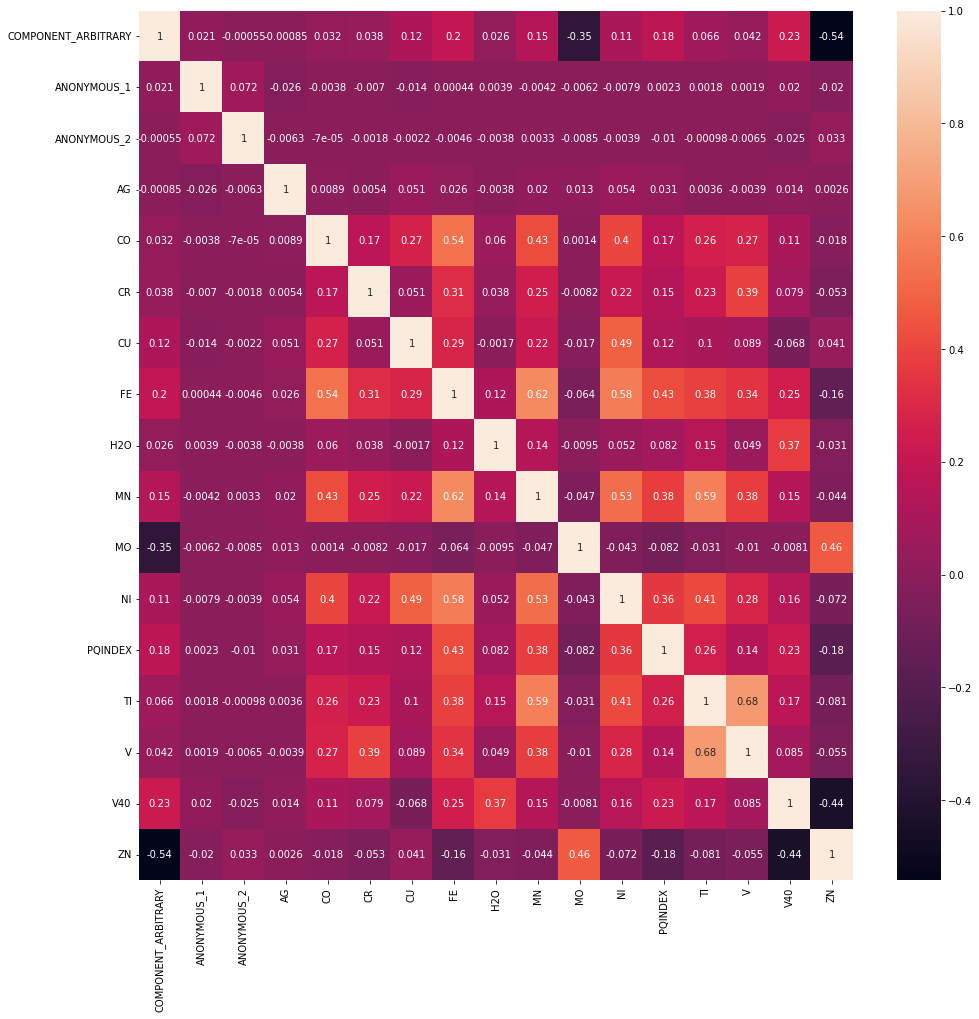

In [ ]:
# Solve Multicollinearity Problem for Regression
corr = train[test_cols].corr()
plt.figure(figsize=(16, 16))
sns.heatmap(data=corr, annot=True)
plt.show()

**Threshold = 0.6**

MN, FE

V, TI

**Threshold = 0.5**

FE, CO

NI, FE

NI, MN

TI, MN

ZN, COMPONET_ARBITRARY(음)

In [ ]:
train.COMPONENT_ARBITRARY

0        3
1        2
2        2
3        3
4        3
        ..
14090    3
14091    1
14092    3
14093    2
14094    2
Name: COMPONENT_ARBITRARY, Length: 14095, dtype: int64

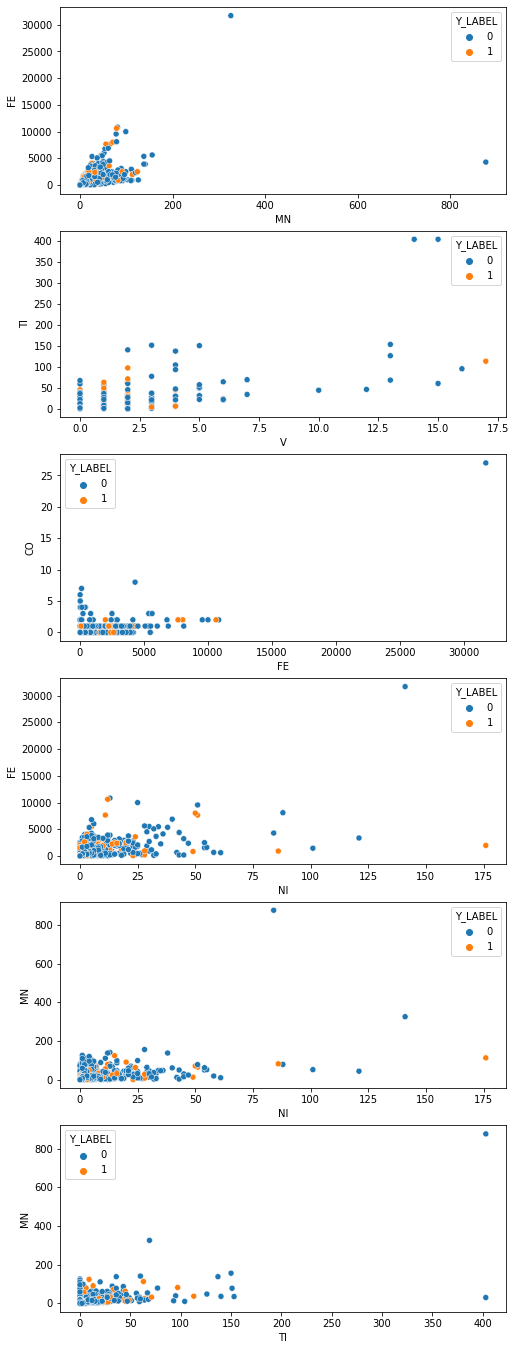

In [ ]:
_,ax = plt.subplots(6, 1, figsize=(8, 24))

sns.scatterplot(data=train, x='MN', y='FE', hue='Y_LABEL', ax=ax[0])
sns.scatterplot(data=train, x='V', y='TI', hue='Y_LABEL', ax=ax[1])
sns.scatterplot(data=train, x='FE', y='CO', hue='Y_LABEL', ax=ax[2])
sns.scatterplot(data=train, x='NI', y='FE', hue='Y_LABEL', ax=ax[3])
sns.scatterplot(data=train, x='NI', y='MN', hue='Y_LABEL', ax=ax[4])
sns.scatterplot(data=train, x='TI', y='MN', hue='Y_LABEL', ax=ax[5])
# sns.scatterplot(data=train, x='COMPONET_ARBITRARY', y='ZN', hue='Y_LABEL', ax=ax[6])
plt.show()

# Modeling process
1. Load data and library(module)

2. EDA

3. Preprocessing & Feature Engineering

4. Check class imbalance & Train data split

5. Train

6. Hyper-parameter tuning

7. Evaluation

In [ ]:
# preprocessing
# recall_score를 줄여서 성능을 높인다

Binarizer = Binarizer(threshold=0.1)
binar_pred_train = clf.predict_proba(X_train)
binar_pred_train2 = clf2.predict_proba(X_train)
pred_proba = clf.predict_proba(X_val)
pred_proba2 = clf2.predict_proba(X_val)

pred_train_clf = Binarizer.fit_transform(binar_pred_train)[:, 1]
pred_train_clf2 = Binarizer.fit_transform(binar_pred_train2)[:, 1]
pred_test_clf = Binarizer.fit_transform(pred_proba)[:, 1]
pred_test_clf2 = Binarizer.fit_transform(pred_proba2)[:, 1]

In [ ]:
class oil:
    def __init__(self, train, test):
        base_path = '/content/drive/MyDrive/dacon/oil/'
        self.load_path = base_path + 'data/'
        self.save_path = base_path + 'submission/'
        self.train = pd.read_csv(self.load_path + 'train.csv')
        self.test = pd.read_csv(self.load_path + 'test.csv')
        self.submission = pd.read_csv(self.load_path + 'sample_submission.csv')
    
    def make_X_y(self) -> None:
        self.X = self.train.drop(columns=['ID', 'Y_LABEL'])
        self.y = self.train.Y_LABEL
        self.test = self.test.drop(columns=['ID'])

    def reset_data(self, mode: str=None):
        if mode is None:
            self.train = pd.read_csv(self.load_path + 'train.csv')
            self.test = pd.read_csv(self.load_path + 'test.csv')
        elif mode == 'train':
            self.train = pd.read_csv(self.load_path + 'train.csv')
        elif mode == 'test':
            self.test = pd.read_csv(self.load_path + 'test.csv')

    def split(self, X, y):
        return train_test_split(X, y, test_size=0.25, random_state=42)

    def multilinearity(self, threshold: float|list=0.7):
        pass
    
    def feature_importance_remove(self, threshold: float|list=0.01):
        pass
    
    def drop_columns(self, columns):
        try:
            if type(columns) == list:
                for col in columns:
                    if col in self.X_test.columns:
                        self.X = self.X.drop(columns=[col])
                        self.X_test = self.X_test.drop(columns=[col])
                    else:
                        self.X = self.X.drop(columns=[col])

            elif type(columns) == str:
                if col in self.X_test.columns:
                    self.X = self.X.drop(columns=[columns])
                    self.X_test = self.X_test.drop(columns=[columns])
                else:
                    self.X = self.X.drop(columns=[columns])
        except:
            print("Not exist those columns. Don't do that")
                
    def modeling(self):
        """
        feature_importance 제거를 위한 기본 모델
        """
        pass

    def grouping(self, categorical_feature: str='COMPONENT_ARBITRARY') -> dict:
        group = {}
        for criteria in self.train[categorical_feature].unique():
            print(f"dividing my df on {criteria}")
            temp_df = self.train.loc[self.train[categorical_feature] == criteria, :].drop(columns=categorical_feature)
            group.update({criteria: temp_df})
        
        return group

    def sampling(self, X, y, sampling_mode: str='under', sampler_type: str='RandomUnderSampler'):
        """
        Parameters
        sampling_mode :
        - 'under' : undersampling(default)
          - 
        - 'over' : oversampling
        - 'hybrid' : under + over
        """
        self.samplers = {
            "under" : {
                'RandomUnderSampler': RandomUnderSampler(),
                'TomekLinks': TomekLinks(),
                'CondensedNearestNeighbour': CondensedNearestNeighbour(), 
                'OneSidedSelection': OneSidedSelection(),
                'EditedNearestNeighbours': EditedNearestNeighbours(),
                'NeighbourhoodCleaningRule': NeighbourhoodCleaningRule()
            },

            "over" : {
                'RandomOverSampler': RandomOverSampler(),
                'ADASYN': ADASYN(),
                'NeighbourhoodCleaningRule': NeighbourhoodCleaningRule()
            },

            "hybrid" : {
                'SMOTEENN': SMOTEENN(),
                'SMOTETomek': SMOTETomek()
            }
        }

        X2, y2 = sampling_method_info[sampling_mode][sampler_type].fit_resample(X, y)
        return X2, y2
    
    def report(X: pd.DataFrame, y: pd.DataFrame, sampling_method: callable = None, dimensionality: callable = None, model: callable = None) -> str: 
        """
        사용법:
        pca = PCA()
        rfc = RandomForestClassifier()
        rmu = RandomUnderSampler()
        pipine(rmu, pca, rfc)
        """
        pipeline = Pipeline([('sampling_method', sampling_method),
                             ('dimensionality', dimensionality),
                             ('model', model)]) # sampling method, dimensionality, model
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        pipeline.fit(X_train, y_train)
        y_hat = pipeline.predict(X_test)
        #print(type(classification_report(y_test, y_hat)))
        return classification_report(y_test, y_hat)

    def data_split(self):
        pass

    def make_full_testset(self, encoder):
        train_cols = list(X.columns)
        test_cols = list(test.columns)
        resid_cols = list(set(train_cols) - set(test_cols))

        self.X2 = X.drop(columns=resid_cols)
        y_list = [X[col] for col in resid_cols]
        final_models = []

        for y, col in zip(y_list, resid_cols):
            errors = []
            # set the weak(?) leaners
            models = [RandomForestRegressor(random_state=42),
                      DecisionTreeRegressor(random_state=42),
                      LGBMRegressor(random_state=42),
                      XGBRegressor(random_state=42)]

            X2_train, X2_val, y_train, y_val = train_test_split(self.X2, y, test_size=0.25, random_state=42)

            for model in models:
                name = str(model).split('(')[0]
                model.fit(X2_train, y_train)
                predict = model.predict(X3_val)
                mae = mean_absolute_error(y_val, predict)
                errors.append(mae)
            
            min_error_index = errors.index(min(errors))
            final_models.append(models[min_error_index])

        if 'COMPONENT_ARBITRARY' in test.columns:
            test['COMPONENT_ARBITRARY'] = encoder.transform(test['COMPONENT_ARBITRARY'])
            test_num_cols = list(test.columns.values)
            test_num_cols.remove('COMPONENT_ARBITRARY')

        ss = StandardScaler()
        ss.fit(X[test_num_cols])
        test[test_num_cols] = ss.transform(test[test_num_cols])

        for model, col in zip(final_models, resid_cols):
            test[col] = model.predict(test[test_cols])

        return test

    def make_submission(self, test: pd.DataFrame):
        # Check submission file name and define file name
        if 'submission_bike.csv' in os.listdir(self.save_path):
            count = 0
            for name in os.listdir(self.save_path):
                if 'submission_bike' in name:
                    count += 1
            filename = f"submission_bike{count + 1}.csv"
        else:
            filename = 'submission_bike.csv'

        # Export submission file
        self.submission.Y_LABEL = self.main_model.predict(test)
        self.submission.to_csv(self.save_path + filename, index=False)

# ---------------------------------------------------------------------------- #
#          Make Sampling Pipeline for solving class imbalance problem          #
# ---------------------------------------------------------------------------- #

    def random_forest_call(self, split_data) :
        """
        main use will be supplement function for classifier_with_group
        """
        classifier_without_dic = RandomForestClassifier()  # Random Forest 분류기 불러오기
        acc_dic = {}
        for criteria, (X_train, X_test, y_train, y_test) in split_data.items() : 
            classifier_without_dic.fit(X_train, y_train) # Random Forest 학습을 위해 parameter 채우기
            pred = classifier_without_dic.predict(X_test) # Random Forest 테스트를 위해 parameter 채우기
            acc = f1_score(y_test, pred)  # f1_score 계산
            acc_dic[f"{criteria}"] = acc
            #print(classification_report(tuple_dic[2], pred))
            print("f1_score : %.3f" % acc)

        return classifier_without_dic, acc_dic

    def classifier_with_group(self, classifier, dic) : 
        """
        return list that contains all classifier for each group 
        """
        classifier_list = []
        for key in dic : 
            df = dic[key]
            classifier_with_group = self.random_forest_call(X_train = df[0], y_train = df[2], X_test = df[1], y_test = df[3])
            classifier_list.append(classifier_with_group)
        return classifier_list

# ---------------------------------------------------------------------------- #
#                 Make Model Pipeline for the multiple tests                   #
# ---------------------------------------------------------------------------- #

class Ensemble:
    """
    Ensemble & Optimize 3 models(RandomForest, XGBoost, LightGBM)
    - (model_type : Classifier / Regressor) Ensemble with (ensemble : voting / stacking)
    """
    def __init__(self, metric: str, learner: str='auto', ensemble: str='voting'):
        """
        ensemble : 'voting', 'stacking'
        """
        self.final_ensemble = None        # Final Ensemble model
        self.models = {
            'RF': None,
            'XGB': None,
            'LGBM': None
        }
        
        # self.metric_dict[self.type_][self.metric_]
        self.metric_dict = {
            'classification': {
                'accuracy_score': accuracy_score,
                'f1_score': f1_score,
                'auc': auc
            },
            'regression': {
                'mae': mean_absolute_error,
                'mse': mean_squared_error,
                'msle': mean_squared_log_error,
                'mape': mean_absolute_percentage_error,
                'r2_score': r2_score
            }
        }
        # self.metric_direction_dict[self.type_][self.metric_]
        self.metric_direction_dict = {
            'classification': {
                'accuracy_score': 'maximize',
                'f1_score': 'maximize',
                'auc': 'maximize'
            },

            'regression': {
                'mae': 'minimize',
                'mse': 'minimize',
                'rmse': 'minimize',
                'msle': 'minimize',
                'rmsle': 'minimize',
                'mape': 'minimize',
                'r2_score': 'maximize'
            }
        }

        # Initializing hyper-parameter for each model
        # self.param[self.learner_]
        self.param = {
            'RF' : {'learning_rate': 0.001,
                    'n_jobs': -1,
                    'random_state': 42},

            'XGB' : {'learning_rate': 0.001,
                     'nthread' : -1,
                     'n_jobs': -1,
                     'tree_method': 'gpu_hist',
                     'predictor': 'gpu_predictor',
                     'random_state': 42},
                      
            'LGBM' : {'learning_rate': 0.001,
                      'n_jobs': -1,
                      'random_state': 42}
        }

        # self.learners[self.type_][self.learner_]
        self.learners = {
            'classification' : {
                'RF': RandomForestClassifier,
                'XGB': XGBClassifier,
                'LGBM': LGBMClassifier
            },
            
            'regression' : {
                'RF': RandomForestRegressor,
                'XGB': XGBRegressor,
                'LGBM': LGBMRegressor
            }
        }

        # self.voters[self.type_][self.emsemble_]
        self.voters = {
            'classification' : {
                'voting' : VotingClassifier,
                'stacking' : StackingClassifier
            },
            
            'regression' : {
                'voting' : VotingRegressor,
                'stacking' : StackingRegressor
            }
        }

        # 'classification' , 'regression'
        self.type_ = ''
        self.learner_ = ['RF', 'XGB', 'LGBM'] if learner == 'auto' else [learner]
        self.ensemble_ = ensemble if ensemble in ['voting', 'stacking'] else 'voting'
        self.metric_ = metric

    def make_weights(self, N: int) -> list:
        # x+y+z = 5인 음이 아닌 정수 (x, y, z) 순서쌍 만들기
        weights = []
        for i in range(N+1):
            for j in range(N+1-i):
                k = N-i-j
                temp = [i/N, j/N, k/N]
                weights.append(temp)
        return weights
        
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series | np.ndarray, N: int=5) -> None:
        for learner in self.learner_: 
            # RF, XGB, LGBM 순서대로 hyper-parameter tuning
            param = self.optimizer(X_train, y_train, learner, 250)
            # Hyper-parameter fix + tuning
            self.param[learner].update(param)
            # Set up final models
            self.models[learner] = self.learners[self.type_][learner](**self.param[learner])
            self.models[learner].fit(X_train, y_train)
        
        estimators = [(learner, self.models[learner]) for learner in self.learner_]
        weights = self.make_weights(N)
        
        # 'weights': weights,
        ensemble_param = {
            'estimators': estimators,
            'n_jobs': -1
        }
        if self.ensemble_ == 'voting':
            ensemble_param.update({'voting': 'soft'})
        
        self.final_ensemble = self.voters[self.type_][self.ensemle_](**ensemble_param)

        grid_params = {'weights': weights}
        grid_Search = GridSearchCV(param_grid = grid_params, estimator=self.final_ensemble, scoring=self.metric_dict[self.type_][self.metric_])
        grid_Search.fit(X_train, y_train)
        self.final_ensemble = grid_Search.best_estimator_

    def predict(self, X_test: pd.DataFrame) -> np.ndarray:
        return self.final_ensemble.predict(X_test)

    def score(self, y_test: pd.Series | np.ndarray, y_pred: pd.Series | np.ndarray) -> float:
        return self.metric_dict[self.type_][self.metric_](y_test, y_pred)

    def K_fold(self, model, X, y, cv) -> list:
        scores = []
        folds = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        if cv == 1:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/cv, random_state=42)
            model.fit(X_train, y_train, verbose=False)
            score = self.score(y_val, model.predict(X_val))
            scores.append(score)
        else:
            for train_idx, val_idx in folds.split(X, y):
                X_train = X.iloc[train_idx, :]
                y_train = y.iloc[train_idx]
                
                X_val = X.iloc[val_idx, :]
                y_val = y.iloc[val_idx]
                
                model.fit(X_train, y_train, verbose=False)
                score = self.score(y_val, model.predict(X_val))
                scores.append(score)

        return scores

    def objective(self, trial: Trial, X, y, learner: str, cv: int=5) -> float:
        temp = copy.deepcopy(self.param[learner])
        
        if learner == 'RF': # RandomForest
            param = {
                "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
                'max_depth':trial.suggest_int('max_depth', 8, 16),
                'learning_rate': 0.05
            }

        elif learner == 'XGB': # XGB
            param = {
                "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
                'max_depth':trial.suggest_int('max_depth', 8, 16),
                'min_child_weight':trial.suggest_int('min_child_weight', 1, 300),
                'gamma':trial.suggest_int('gamma', 1, 3),
                'learning_rate': 0.05,
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
                'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
                'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
                'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0] )
            }

        elif learner == 'LGBM': # LGBM
            param = {
                'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
                'max_depth': trial.suggest_int('max_depth', 1, 10, step=1, log=False), 
                'learning_rate': 0.05,
                'n_estimators': trial.suggest_int('n_estimators', 8, 1024, step=1, log=True), 
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=1, log=False), 
                'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
                'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
                'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
                'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0)
            }

        else:
            raise Exception("Not exist those model. Please choose the number in [0, 1, 2]\nTry again.")
        
        # Set up param
        temp.update(param)
        param = temp

        # Set up the model by flag
        model = self.learners[self.type_][learner](**param)
        
        # K-fold cross validation
        scores = self.K_fold(model, X, y, cv)

        return np.mean(scores)
    
    def optimizer(self, X: pd.DataFrame, y: pd.Series | np.ndarray,
                  learner: str, n_trials: int=100) -> dict:
        
        study = optuna.create_study(direction=self.metric_direction_dict[self.type_][self.metric_], 
                                    sampler=TPESampler())
        study.optimize(lambda trial : self.objective(trial, X, y, learner), n_trials=n_trials)
        print('Best trial: score {},\nparams: {}'.format(study.best_trial.value, study.best_trial.params))
        return study.best_trial.params

class BinaryCalssifier(Ensemble):
    # Child Class
    """
    metric : F1 score
    """
    def __init__(self, metric: str, learner: str='auto', ensemble: str='voting'):
        super().__init__(metric, learner, ensemble)
        # 'classification' Type
        self.type_ = 'classification'
        self.param['LGBM'] = {'objective': 'binary',
                              'learning_rate': 0.05,
                              'random_state': 42}   # LightGBM

class Regressor(Ensemble):
    # Child Class
    """
    metric : R-squared score
    """
    def __init__(self, metric: str, learner: str='auto', ensemble: str='voting'):
        super().__init__(metric, learner, ensemble)
        # 'regression' Type
        self.type_ = 'regression'